<a href="https://colab.research.google.com/github/chengning-zhang/Intern-SWIB/blob/master/First_week_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA



Load libraries and read data

In [0]:
!pip install shap

In [0]:
import pandas as pd
from patsy import dmatrix
import numpy as np
from sklearn import tree
import shap
from sklearn.ensemble import RandomForestRegressor


In [0]:
def load_basic_data(fileName):

        tempDF = pd.read_parquet(fileName)
                    
        returnDF = tempDF.pivot(index='date', columns='sedol', values='d_return')

        returnDF.sort_index()

        returnDF.index = pd.to_datetime(returnDF.index)

        priceDF = tempDF.pivot(index='date', columns='sedol', values='LAST_PRICE')

        priceDF.sort_index()

        priceDF.index = pd.to_datetime(priceDF.index)  


        sectorDF = tempDF.pivot(index='date', columns='sedol', values='sector')

        sectorDF.sort_index()

        sectorDF.index = pd.to_datetime(sectorDF.index)  


        dollarVolumeDF = tempDF.pivot(index='date', columns='sedol', values='dollarVolume')

        dollarVolumeDF.sort_index()

        dollarVolumeDF.index = pd.to_datetime(dollarVolumeDF.index)

        return tempDF
        #, returnDF, priceDF, sectorDF,dollarVolumeDF

tempDF = load_basic_data("/content/drive/My Drive/SWIB Quant Intern/SP500.pq")

In [4]:
tempDF.dropna()

,date,sedol,sector,mktcap,d_return,LAST_PRICE,VOLUME_AVG_30D,dollarVolume
0,2001-09-17,2001692,Industrials,2779.3441,-0.393939,18.00,1331822.80,2.397281e+07
1,2001-09-17,2002305,Health Care,78393.6045,0.020190,50.53,2240750.00,1.132251e+08
2,2001-09-17,2002479,Utilities,14638.9093,-0.051724,27.50,2179436.50,5.993450e+07
3,2001-09-17,2005973,Information Technology,162099.8412,-0.032445,93.34,6611664.00,6.171327e+08
4,2001-09-17,2007849,Information Technology,3503.8872,-0.144304,10.14,4347550.00,4.408416e+07
...,...,...,...,...,...,...,...,...
2430669,2020-06-05,BYY8XK8,Utilities,29288.1390,0.003025,92.85,1702807.90,1.581057e+08
2430670,2020-06-05,BZ07BW4,Consumer Staples,38033.6860,0.018472,72.23,2354668.00,1.700777e+08
2430671,2020-06-05,BZ12WP8,Materials,116213.0030,0.041024,221.28,1950671.00,4.316445e+08
2430672,2020-06-05,BZ6TS23,Real Estate,33172.6850,-0.011344,297.18,704585.80,2.093888e+08




1.   In this S&P 500 data, there is no missing values. 
2.   This is daily stock data, from 2001-09-017 to 2020-06-05, total of 4853 days. 
3.   The number of stocks in our sample is 1069, with the average number of stocks per day is approximately 500.

4.  There are some stocks whose name is mainly characters instead of numbers, only appear once. 







In [5]:
tempDF['sedol'].value_counts().tail(20)

BDVJJQ5    1
BD4LHG4    1
BYNF418    1
BGLRLT7    1
BFD1TJ6    1
BFXZQZ3    1
BZ16HK0    1
BYMMZL7    1
BD845X2    1
BYXHTC0    1
BDTYZ53    1
BYWLRV8    1
B1G35K4    1
BDQYWV1    1
BJTJGC4    1
BYW4289    1
BD3BX01    1
BD85SC5    1
BDB2RN7    1
BZ5YFM8    1
Name: sedol, dtype: int64

In [6]:
num_stocks_ts = tempDF['date'].value_counts()
#num_stocks_ts = num_stocks_ts.to_frame()
num_stocks_ts = pd.DataFrame({'date':pd.to_datetime(num_stocks_ts.index), 'num of stocks': num_stocks_ts} ).sort_values(by = ['date'])
num_stocks_ts = num_stocks_ts.set_index('date')
#num_stocks_ts = num_stocks_ts.sort_index()
num_stocks_ts.sort_values(by = ['num of stocks']).head(7)


,num of stocks
date,
2007-07-27,1
2008-07-22,2
2008-07-23,2
2008-07-24,2
2008-07-25,2
2018-02-05,491
2018-02-07,491


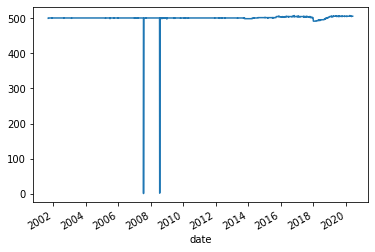

In [7]:
num_stocks_ts['num of stocks'].plot()

# Build model

let $t \in \{1,2,....,4853 \}$ denote the date, 
let $ i \in \{1,2,....,1069 \}$ denote the stock index. 
The response variable is $\textbf{d_return}$, denoted as $r_{i,t}$, of stock i and day t. 
The predictive characteristics are denoted as P-dimensional vector $z_{i,t}$, which includes 
$\textbf{date,		sector,	mktcap,	LAST_PRICE,	VOLUME_AVG_30D,	dollarVolume}$.
date is 1,2....4853 following "citi-bank" paper.

1.  we consider regression problem, which means that the objective function is minimization of MSE. 

   $r_{i,t+1} = g(z_{i,t}) + \epsilon_{i,t+1}$
   
       

2.  we consider classification problem, for example a binary classification of whether d_return is positive or not. 
   
   $P(r_{i,t+1} > 0 | z_{i,t}) = g(z_{i,t})$

Following the paper(ML), The g function depends neither on i or t. By maintaining the same form over time and across different stocks, the model leverages information from the entire panel and every individual asset. Also g(.) depends on z only through $z_{i,t}$.


We split sample into 2 disjoint time periods, 2001-2013 as training, 2014-2020 as testing.

Regarding performance evaluation for regression, we use R square or MSE $R^2_{oos} = 1 - \frac{\sum_{(i,t)\in test}(r_{i,t+1}-\hat{r}_{i,t+1})^2}{\sum_{(i,t)\in test} r^2_{i,t+1}}$, 
and F1,accuracy for classification.

There are some problems with our model so far: The biggest problem is feature engineering. In the paper, they build 94 stock-level predictive characteristics, and 74 industry dummies(SIC), 8 marcoeconomic predictors. 
Another problem is the time lag, I may use $z_{i,t+1}$ instead of $z_{i,t}$ to predict $r_{i,t+1}$




### Random Forest g(.)


random forest does not support cat features, need preprocessing first

**random forest does not need feature scaling!**

In [0]:
# add time as new feature
date = list(tempDF['date'].unique())
date = dict(zip (date,np.arange(len(date))))
tempDF['time'] = tempDF['date'].map(date)

In [9]:
# convert cat to one-hot
formula = 'C(sector) + mktcap	 +	LAST_PRICE +	VOLUME_AVG_30D	+ dollarVolume + time' 
print(formula)
X = dmatrix(formula, tempDF,return_type= 'dataframe')
X['time'] = X['time'].astype(int)
Y = tempDF.d_return

C(sector) + mktcap	 +	LAST_PRICE +	VOLUME_AVG_30D	+ dollarVolume + time


In [0]:
# Split training and testing data, 2001- 2013,    2014-2020
# print(date['2013-12-31'])
X_tr = X[X['time'] <= 3199]; X_te = X[X['time'] > 3199]
Y_tr = Y[0:len(X_tr)]; Y_te = Y[len(X_tr):]

In [12]:
regr = RandomForestRegressor(max_depth=2,random_state=0)
regr.fit(X_tr, Y_tr)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=2, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [14]:
regr2 = RandomForestRegressor(max_depth=2,random_state=0)
regr2.fit(X, Y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=2, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

# Model evaluation 

In [16]:
regr.score(X_te,Y_te)

-4.650104046666215e-05

# SHAP, prediction interpretation

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


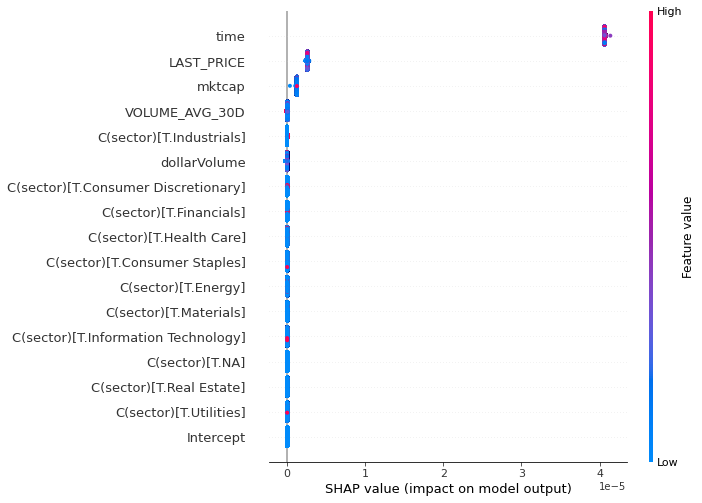

In [13]:
explainer = shap.TreeExplainer(regr)
shap_values = explainer.shap_values(X_te)

shap.summary_plot(shap_values, X_te)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


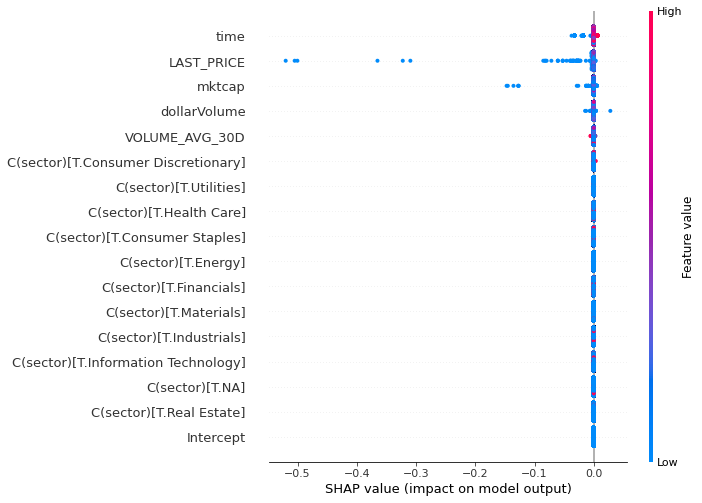

In [15]:
explainer = shap.TreeExplainer(regr2)
shap_values2 = explainer.shap_values(X)

shap.summary_plot(shap_values2, X)

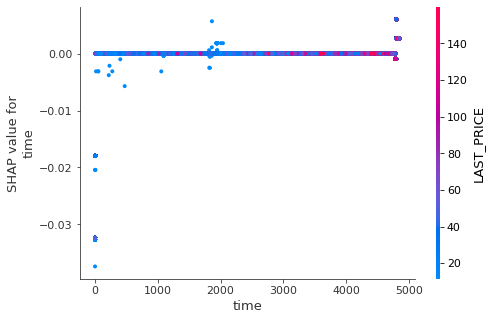

In [17]:
shap.dependence_plot("time", shap_values2, X)

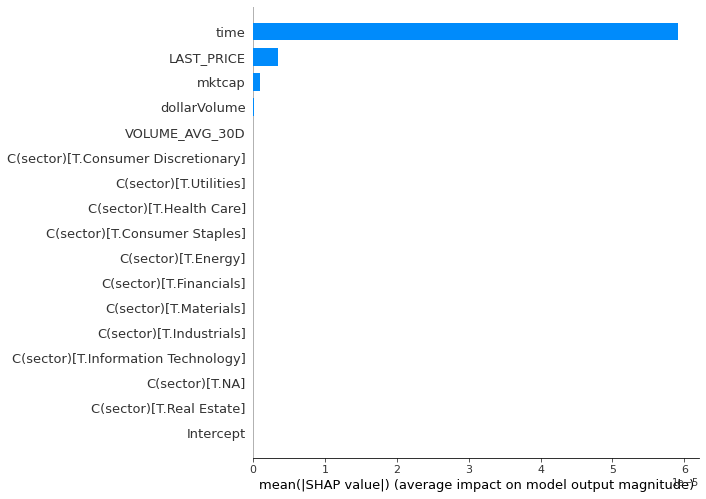

In [18]:
shap.summary_plot(shap_values2, X, plot_type="bar")
